# Capsule V1 Tiny

This implementation doesn't have the decoder structure.

> Dynamic Routing Between Capsules. [arXiv:1710.09829v1](https://arxiv.org/abs/1710.09829)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from torchvision import datasets

## Load MINST Data

- download mnist dataset
    - [http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz)
- extract them to a directory

In [2]:
trainImage = datasets.mnist.read_image_file('../Dataset/MNIST/train-images.idx3-ubyte')
trainLabel = datasets.mnist.read_label_file('../Dataset/MNIST/train-labels.idx1-ubyte')
trainImage = trainImage.float() / 255
trainLabel = trainLabel.reshape(-1,1)

N,W,H = trainImage.shape
trainImage = torch.reshape(trainImage, (N,1,W,H))
print(trainImage.shape)
del N,W,H

torch.Size([60000, 1, 28, 28])


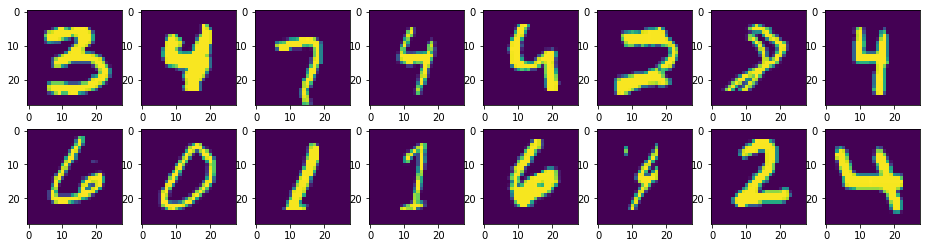

In [3]:
tinp = np.random.choice(trainImage.shape[0], (16,))
tinp = trainImage.data.numpy()[tinp]
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(tinp[i,0])
plt.show()

## Capsule 

- low-layer capsule $\rightarrow$ hight-layer 
- 

### Squashing 

$$
\begin{array}{cc}
v_j = \dfrac{\|s_j\|^2}{1 + \|s_j\|^2} \dfrac{s_j}{\|s_j\|},&
\|s_j\| = \sqrt{\|s_j\|^2_F}
\end{array}
$$

In [4]:
def squashing(s):
    """
    Input:
    - s: (batch, atoms, output_dim)
    Return:
    - v
    """
    vec_squ = torch.sum(s * s, 2, keepdim=True)
    vec_sum = torch.sqrt(vec_squ)
    vec_v = (s * vec_sum) / (1 + vec_squ)
    return vec_v

### Routing algorithm

$$s_j = \sum_i c_{ij} \hat{u}_{j|i}, \quad \hat{u}_{j|i} = W_{ij} u_i$$

$$c_{ij} = \dfrac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}$$

In [5]:
def routing(priors, output_dim, iteration=3):
    """
    batch, input_dim, output_dim, output_atoms
    Input:
    - hatu: (batch, input_dim, atoms) $w \cdot u$
    - nextlayer: a number 
    - iteration: usually 3
    """
    logits = torch.zeros(*priors.shape).cuda()
    for i in range(iteration-1):
        probs = F.softmax(logits, dim=2)
        outputs = squashing((probs * priors).sum(dim=2, keepdim=True))
        delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
        logits = logits + delta_logits
    probs = F.softmax(logits, dim=2)
    outputs = squashing((probs * priors).sum(dim=2, keepdim=True))
    return outputs, logits

### Capsule Model

In [6]:
class CapsuleModule(nn.Module):
    def __init__(self):
        super(CapsuleModule, self).__init__()
        self.conv1 = nn.Conv2d(1,32, (9,9), stride=1)
        self.primary_capsule = nn.Conv2d(32, 4*8, (9,9), stride=2, groups=4)

        # num_capsules, 1, num_route_nodes, in_channels, out_channels
        self.w = Parameter(torch.Tensor(10, 1, 4*6*6, 8, 8).normal_())
        
        self.logits = None # for routing
        
    def forward(self, x, routecount=3):
        """
        Output:
            [batch, output_dim, output_atoms]
        """
        out = F.leaky_relu(self.conv1(x), 0.02) # first layer
        # out (batch,32,6,6)
        out = self.primary_capsule(out) # primary capsule  
        out = torch.transpose(out.view(1, -1, 8, 4*6*6, 1), 2,3)
        priors = torch.sum(out * self.w, dim=3)
        out, self.logits = routing(priors, 10, routecount)
        out = out.squeeze().transpose(0,1)
        classes = torch.sqrt((out * out).sum(dim=-1))
        classes = F.softmax(classes, dim=-1)
        return classes

### Margin Loss

$$L_c = T_c \max(0,m^+ - \|v_c\|)^2 + \lambda (1 - T_c) \max(0, \|v_c\| - m^-)^2$$

In [7]:
def margin_loss(classes, target, mplus=0.9, mminus=0.1, l=0.5):
    """
    - vc: module output, (N,L,J)
    - target: one hot label
    - mplus: $m^+$
    - mminus: $m^-$
    - l: $lambda$
    """
    thezero = torch.zeros_like(classes)
    Lc1 = torch.where(mplus > classes, mplus-classes, thezero)
    Lc2 = torch.where(mminus < classes, classes-mminus, thezero)
    Lc = target * (Lc1*Lc1) + l*(1.0-target)*(Lc2*Lc2)
    return torch.mean(Lc)

### Train

In [26]:
capsule = CapsuleModule().cuda()
optim = torch.optim.Adam(capsule.parameters(), lr=5e-3)

In [29]:
# 60000 images
for i in range(0,50000,500):
    tImage = trainImage[i:i+500].cuda()
    tLabel = torch.zeros(500, 10).scatter_(1, trainLabel[i:i+500], 1).cuda()
    optim.zero_grad()
    classes = capsule(tImage)
    loss = margin_loss(classes, tLabel)
    loss.backward()
    optim.step()
    if i % 4000 == 0:
        print("offset {:05d}, loss {:.8f}".format(i, loss))

offset 00000, loss 0.01003233
offset 04000, loss 0.00994003
offset 08000, loss 0.01012537
offset 12000, loss 0.00997125
offset 16000, loss 0.00967296
offset 20000, loss 0.00985782
offset 24000, loss 0.00938239
offset 28000, loss 0.01048219
offset 32000, loss 0.01097231
offset 36000, loss 0.00985099
offset 40000, loss 0.00905483
offset 44000, loss 0.00955107
offset 48000, loss 0.00933020


### test output

In [31]:
tout = capsule(trainImage[50000:50000+500].cuda(), 2)
capout = torch.argmax(tout,dim=1)
# print(capout)

actlabel = trainLabel[50000:50000+500,0].cuda()
# print(actlabel)

print(torch.sum(capout == actlabel).float() / 500)

tensor(0.9680, device='cuda:0')
